In [ ]:
import os
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
#import tensorflow as tf
from matplotlib import pyplot as plt

import seaborn as sns
import cv2
import glob

#print("Tensorflow version " + tf.__version__)

In [ ]:
import warnings
import sys
from tqdm import tqdm

import random
from sklearn.model_selection import train_test_split
%matplotlib inline

from urllib.parse import urlparse

In [ ]:
pip install pytorch-lightning transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 707 kB 14.6 MB/s 
     |████████████████████████████████| 4.9 MB 63.8 MB/s 
     |████████████████████████████████| 365 kB 84.6 MB/s 
     |████████████████████████████████| 5.9 MB 84.8 MB/s 
     |████████████████████████████████| 419 kB 83.5 MB/s 
     |████████████████████████████████| 120 kB 88.5 MB/s 
     |████████████████████████████████| 6.6 MB 72.1 MB/s 
     |████████████████████████████████| 212 kB 94.8 MB/s 
     |████████████████████████████████| 115 kB 93.2 MB/s 
     |████████████████████████████████| 127 kB 100.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorb

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image, ImageOps
import numpy as np
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_img_path = '/content/drive/MyDrive/COVID/train/xrays/'
train_mask_path = '/content/drive/MyDrive/COVID/train/masks/'
val_img_path = '/content/drive/MyDrive/COVID/val/xrays/'
val_mask_path = '/content/drive/MyDrive/COVID/val/masks/'
test_img_path = '/content/drive/MyDrive/COVID/test/xrays/'
test_mask_path = '/content/drive/MyDrive/COVID/test/masks/'

In [ ]:
path_img = '/content/drive/MyDrive/COVID19SEG/COVID/xrays/'
path_mask = '/content/drive/MyDrive/COVID19SEG/COVID/masks/'

In [ ]:
def images(path_images, img_height, img_width):
  images = []
  for img_path in tqdm(glob.glob(path_images+"*.png")):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resize = cv2.resize(img, (img_height, img_width))
    img_resize = img_resize/255.0
    img_resize = img_resize.astype(np.float32)
    images.append(img_resize)

  images = np.array(images).reshape(len(images), img_height, img_width, 1)

  return images

In [ ]:
def mask(path_mask, img_height, img_width):
  mask = []
  for msk_path in tqdm(glob.glob(path_mask+"*.png")):
    msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
    msk_resize = cv2.resize(msk, (img_height, img_width))
    msk_resize = msk_resize/np.max(msk_resize)
    msk_resize = msk_resize > 0.5
    msk_resize = msk_resize.astype(np.float32)
    mask.append(msk_resize)

  mask = np.array(mask).reshape(len(mask), img_height, img_width, 1)

  return mask

In [ ]:
Xray_img = images(path_img, 256, 256)

100%|██████████| 3616/3616 [00:52<00:00, 69.30it/s] 


In [ ]:
mask = mask(path_mask, 256, 256)

100%|██████████| 3616/3616 [00:46<00:00, 77.38it/s] 


In [ ]:
Xray_img[0].shape

(256, 256, 1)

In [ ]:
#mask_new = np.array(mask).reshape(len(mask), 256, 256, 1)

Text(0.5, 1.0, 'COVID X-Ray')

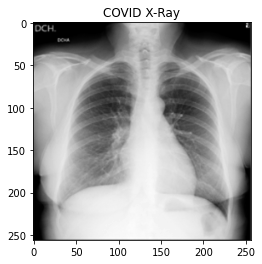

In [ ]:
plt.imshow(Xray_img[35].reshape(256,256), cmap='gray')
plt.title('COVID X-Ray')

Text(0.5, 1.0, 'COVID Mask')

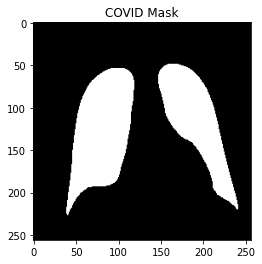

In [ ]:
plt.imshow(mask[35].reshape(256, 256), cmap='gray')
plt.title('COVID Mask')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xray_img, mask, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
#from unet import UNet
from torch.utils.data import DataLoader
#from dataset import VocDataset
import torchvision.transforms as T
import torch.nn.functional as F

In [ ]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, img_dir, mask_dir, feature_extractor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.feature_extractor = feature_extractor
        #self.transform = transform

        # self.classes_csv_file = csv_path #os.path.join(self.root_dir, "_classes.csv")
        # with open(self.classes_csv_file, 'r') as fid:
        #     data = [l.split(',') for i,l in enumerate(fid) if i !=0]
        # self.id2label = {x[0]:x[1] for x in data}
        
        image_file_names = [f for f in os.listdir(self.img_dir) if '.png' in f]
        mask_file_names = [f for f in os.listdir(self.mask_dir) if '.png' in f]
        
        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        image = image.convert("RGB")
        segmentation_map = Image.open(os.path.join(self.mask_dir, self.masks[idx]))
        #segmentation_map = segmentation_map.convert("RGB")
        #image = image.resize((512, 512))
        #segmentation_map = segmentation_map.resize((512, 512))
        segmentation_map = segmentation_map.resize((512, 512))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
class SegformerFinetuner(pl.LightningModule):
    
    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        
        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}
        
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512", 
            return_dict=False, 
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        
        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")
        
    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return(outputs)
    
    def training_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes, 
                ignore_index=255, 
                reduce_labels=False,
            )
            
            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}
            
            for k,v in metrics.items():
                self.log(k,v)
            
            return(metrics)
        else:
            return({'loss': loss})
    
    def validation_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        
        return({'val_loss': loss})
    
    def validation_epoch_end(self, outputs):
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
        
        avg_val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]
        
        metrics = {"val_loss": avg_val_loss, "val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        for k,v in metrics.items():
            self.log(k,v)

        return metrics
    
    def test_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
            
        return({'test_loss': loss})
    
    def test_epoch_end(self, outputs):
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
       
        avg_test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}
        
        for k,v in metrics.items():
            self.log(k,v)
        
        return metrics
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)
    
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl
    

In [ ]:
root_dir = '/content/drive/MyDrive/balloons/'
csv_path = '/content/drive/MyDrive/COVID/_classes.csv'

In [ ]:
SIZE = (512, 512)

feature_extractor = SegformerFeatureExtractor(reduce_labels=True)
TRANSFORM = T.Compose(
    [T.ToTensor(), T.Resize(SIZE)]
)
#feature_extractor.reduce_labels = False
#feature_extractor.size = 256

train_dataset = SemanticSegmentationDataset(train_img_path, train_mask_path, feature_extractor)
val_dataset = SemanticSegmentationDataset(val_img_path, val_mask_path, feature_extractor)
test_dataset = SemanticSegmentationDataset(test_img_path, test_mask_path, feature_extractor)


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of Test examples:", len(test_dataset))

Number of training examples: 2643
Number of validation examples: 652
Number of Test examples: 361


In [ ]:
auto_encoder = train_dataset[0]

In [ ]:
auto_encoder["pixel_values"].shape

torch.Size([3, 512, 512])

In [ ]:
auto_encoder["labels"].shape

torch.Size([512, 512, 3])

In [ ]:
auto_encoder["labels"].squeeze().shape

torch.Size([512, 512, 3])

In [ ]:
batch_size = 8
num_workers = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)


In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([8, 3, 512, 512])
labels torch.Size([8, 512, 512, 3])


In [ ]:
classes_csv_file = csv_path #os.path.join(self.root_dir, "_classes.csv")
with open(classes_csv_file, 'r') as fid:
  data = [l.split(',') for i,l in enumerate(fid) if i !=0]
  id2label = {x[0]:x[1] for x in data}

In [ ]:
id2label

{'0': ' background\n', '1': ' object'}

In [ ]:
model = SegformerForSemanticSegmentation()

TypeError: ignored

In [ ]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [ ]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)
          
          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          metrics = metric.compute(num_labels=len(id2label), 
                                   ignore_index=255,
                                   reduce_labels=False, # we've already reduced the labels before)
          )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/331 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
segformer_finetuner = SegformerFinetuner(
    id2label, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    test_dataloader=test_dataloader, 
    metrics_interval=10,
)

Downloading:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#train_dataloader.data

In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.00, 
    patience=10, 
    verbose=False, 
    mode="min",
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")

trainer = pl.Trainer(
    gpus=1, 
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=500,
    val_check_interval=len(train_dataloader),
)
trainer.fit(segformer_finetuner)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.7 M 
-------------------------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


RuntimeError: ignored

In [ ]:
path = '/content/drive/MyDrive/balloons/test/2685563244_b0d5f7eb67_b_jpg.rf.a7a60c235f3f2168ae456b970b15e1f9_mask.png'
read_img = Image.open(path)

In [ ]:
read_img.size

(512, 512)

In [ ]:
xray = '/content/drive/MyDrive/COVID/test/xrays/COVID-3256.png'
covid = Image.open(xray)

In [ ]:
covid.size

(299, 299)

In [ ]:
new_covid = covid.resize((256, 256), Image.ANTIALIAS)

In [ ]:
new_covid.size

(256, 256)